# Basic time series exploration

In [16]:
import numpy as np
import pandas as pd

full_data = pd.read_csv("../data/my_expenses.csv", delimiter = ";", decimal = ",")
full_data.head()

,original,Date,amount_kn,Amount,Note,Currency,Category
0,220 kn interšpar,2021-09-25,220.0,29.20,interšpar,EUR,shopping
1,200kn gym,2021-10-01,200.0,26.54,gym,EUR,gym
2,230kn ducan interspar,2021-10-02,230.0,30.53,ducan interspar,EUR,shopping
3,400 kn lijekovi baka + plivit total,2021-10-04,400.0,53.09,lijekovi baka + plivit total,EUR,baka
4,250 kn lidl,2021-10-08,250.0,33.18,lidl,EUR,shopping


In [17]:
full_data_amounts = full_data.drop(["original", "amount_kn", "Note", "Currency"], axis=1)
full_data_amounts.head()

,Date,Amount,Category
0,2021-09-25,29.20,shopping
1,2021-10-01,26.54,gym
2,2021-10-02,30.53,shopping
3,2021-10-04,53.09,baka
4,2021-10-08,33.18,shopping


In [18]:
daily = full_data_amounts.groupby("Date")[["Amount"]].sum()
daily.head()

,Amount
Date,
2021-09-25,29.20
2021-10-01,26.54
2021-10-02,30.53
2021-10-04,53.09
2021-10-07,39.95


In [19]:
daily.index = pd.to_datetime(daily.index)
daily.index

DatetimeIndex(['2021-09-25', '2021-10-01', '2021-10-02', '2021-10-04',
               '2021-10-07', '2021-10-08', '2021-10-09', '2021-10-12',
               '2021-10-16', '2021-10-20',
               ...
               '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22',
               '2024-03-23', '2024-03-25', '2024-03-26', '2024-03-27',
               '2024-03-28', '2024-03-29'],
              dtype='datetime64[ns]', name='Date', length=502, freq=None)

In [20]:
# Get monthly amounts
monthly = daily.resample("1MS").sum()
print(monthly.head())
print(monthly.tail())

            Amount
Date              
2021-09-01   29.20
2021-10-01  659.76
2021-11-01  840.82
2021-12-01  378.26
2022-01-01  825.94
             Amount
Date               
2023-11-01  2373.00
2023-12-01   937.80
2024-01-01  1235.74
2024-02-01   789.50
2024-03-01   952.70


In [21]:
# Remove 2021-09 because it's inaccurately low
monthly.drop("2021-09-01", axis = 0, inplace = True)

## Creating a Prophet model

In [22]:
# The dataframe should have specific column names
monthly.columns = ["y"]
monthly["ds"] = monthly.index

monthly.reset_index(drop = True)
monthly.head()

,y,ds
Date,,
2021-10-01,659.76,2021-10-01
2021-11-01,840.82,2021-11-01
2021-12-01,378.26,2021-12-01
2022-01-01,825.94,2022-01-01
2022-02-01,551.60,2022-02-01


In [23]:
from prophet import Prophet
model = Prophet()

model.fit(monthly)

20:59:51 - cmdstanpy - INFO - Chain [1] start processing
20:59:51 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# Predict next year
future = model.make_future_dataframe(periods = 12, freq = "MS")
forecast = model.predict(future)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

forecast.tail(13)

,ds,yhat,yhat_lower,yhat_upper
29,2024-03-01,952.140845,712.063052,1188.686724
30,2024-04-01,1028.470628,785.404815,1269.456059
31,2024-05-01,1599.482397,1362.117439,1826.431078
32,2024-06-01,147.252904,-92.954627,377.490573
33,2024-07-01,1856.977252,1591.878950,2100.900653
34,2024-08-01,2533.920093,2289.055415,2778.937716
35,2024-09-01,1278.637344,1047.090666,1509.072445
36,2024-10-01,1686.821793,1459.246363,1930.083580
37,2024-11-01,906.759824,679.943147,1143.140469
38,2024-12-01,1415.911314,1181.699353,1659.316189


c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


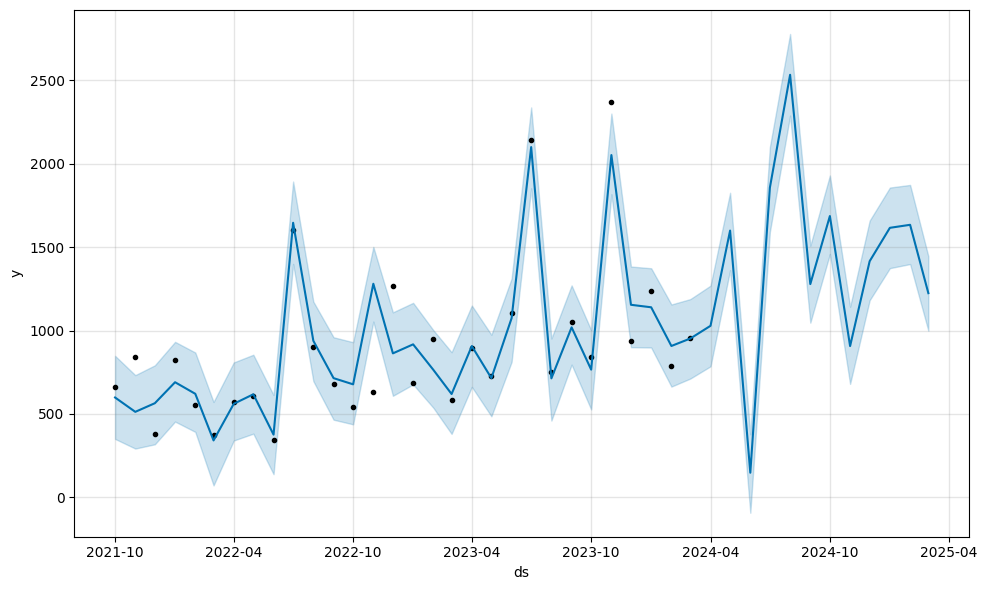

In [25]:
# Automatic plotting of a given dataframe
figure1 = model.plot(forecast)

In [26]:
# Interactive plot
# For monthly data, 1month and 1week, components in general not available
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast)

Saturating forecasts - minimums and maximums

In [27]:
# We need to add an additional column to the dataframe - cap for maximum, floor for minimum, and pass that to the model
monthly["floor"] = 0

# A cap is NEEDED, not optional. Floor is optional.

# Arbitrarily high cap:
monthly["cap"] = 10000
monthly.tail()

,y,ds,floor,cap
Date,,,,
2023-11-01,2373.00,2023-11-01,0,10000
2023-12-01,937.80,2023-12-01,0,10000
2024-01-01,1235.74,2024-01-01,0,10000
2024-02-01,789.50,2024-02-01,0,10000
2024-03-01,952.70,2024-03-01,0,10000


In [28]:
model_logistic = Prophet(growth = "logistic")
model_logistic.fit(monthly)

20:59:51 - cmdstanpy - INFO - Chain [1] start processing
20:59:52 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future = model_logistic.make_future_dataframe(periods = 12, freq = "MS")
future["cap"] = 10000
future["floor"] = 0
future.tail()

,ds,cap,floor
37,2024-11-01,10000,0
38,2024-12-01,10000,0
39,2025-01-01,10000,0
40,2025-02-01,10000,0
41,2025-03-01,10000,0


c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



(0.0, 3000.0)

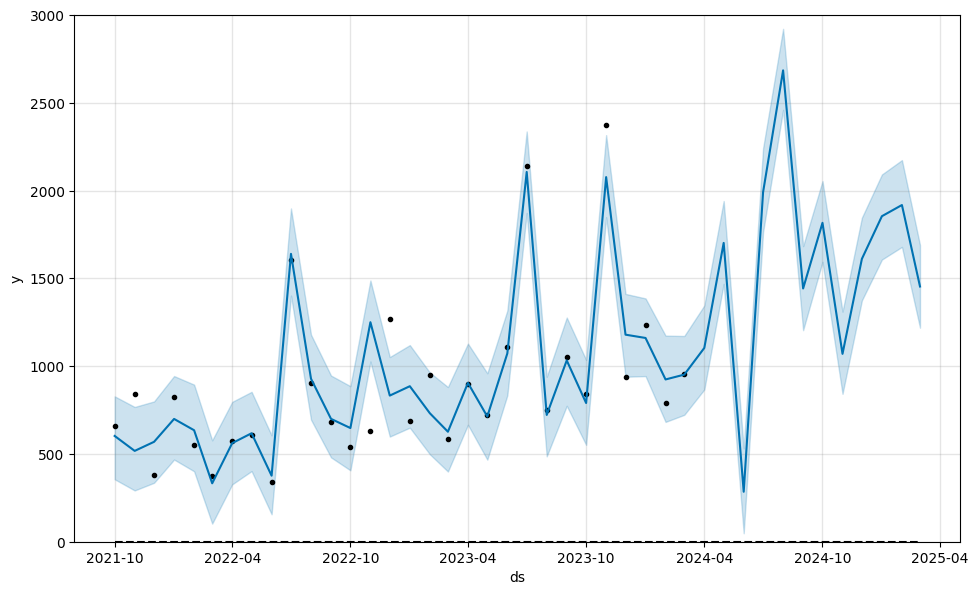

In [30]:
forecast2 = model_logistic.predict(future)
fig_logistic = model_logistic.plot(forecast2)

# Set the axis to not stretch to 10000
axes = fig_logistic.gca()
axes.set_ylim([0, 3000])